In [1]:
# Import useful packages
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Read the dataset
data = pd.read_csv('sph6004_assignment1_data.csv')

## Preprocessing

In [3]:
# Focus on binary classification
data['aki'] = data['aki'].apply(lambda x: 1 if x != 0 else 0)
test = data

In [4]:
# Create dummy variables
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns)

In [5]:
# Too many missing values so dropping doesn't work
# Impute with medians
# KNN imputation is slow
data.fillna(data.median(), inplace=True)

In [6]:
data.head()

,id,aki,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,...,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN
0,36570066,1,79.953141,96.0,104.0,100.083333,103.0,126.0,116.136364,40.0,...,0,0,0,0,0,0,0,0,0,0
1,39307659,0,78.194169,72.0,134.0,97.263158,97.0,127.0,109.833333,56.0,...,0,0,0,0,0,0,0,0,0,1
2,38743306,1,65.602396,60.0,97.0,84.166667,95.0,143.0,112.153846,56.0,...,0,0,0,0,0,1,0,0,0,0
3,32339865,1,64.906629,59.0,87.0,71.461538,113.0,150.0,138.160000,60.0,...,0,0,0,0,1,0,0,0,0,0
4,35526987,1,57.438861,57.0,100.0,82.387097,81.0,127.0,97.672131,47.0,...,0,0,0,0,0,1,0,0,0,0


## Feature selection

In [7]:
from scipy.stats import ttest_ind
# For numerical variables

group0 = data[data['aki']==0]
group1 = data[data['aki']==1]

pvals = np.array(100000)
for i in data.columns[2:160]:
    pval = ttest_ind(group0[i], group1[i])[1]
    pvals = np.append(pvals, pval)
pvals = pvals[1:]

In [8]:
from scipy.stats import chi2_contingency

# For categorical variables
group0 = test[test['aki']==0]
group1 = test[test['aki']==1]
contigency= pd.crosstab(test['aki'], test['gender']) 
p_gender = chi2_contingency(contigency)[1]
contigency= pd.crosstab(test['aki'], test['race']) 
p_race = chi2_contingency(contigency)[1]

pvals = np.append(np.array((p_gender, p_race)), pvals)

In [9]:
from statsmodels.stats.multitest import multipletests

qval = multipletests(pvals, method='bonferroni')[1]
p_adj = multipletests(pvals, method='fdr_bh')[1]

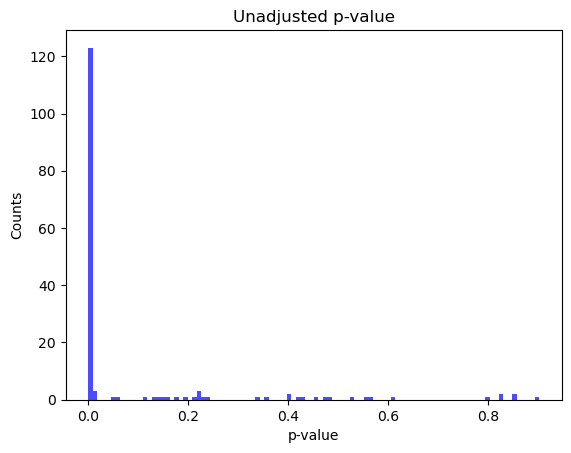

In [10]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(pvals, color='blue', alpha=0.7, bins=100)
plt.title('Unadjusted p-value')
plt.xlabel('p-value')
plt.ylabel('Counts')

# Show the plot
plt.show()

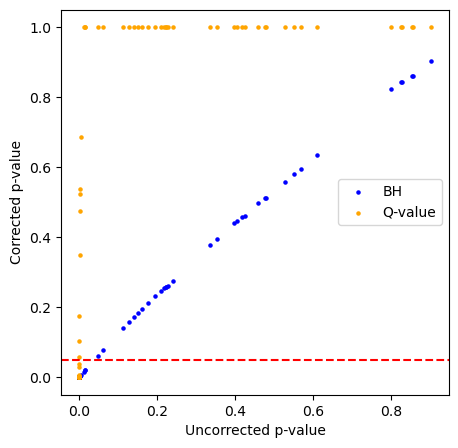

In [11]:
plt.figure(figsize=(5,5))

plt.scatter(pvals, p_adj, color='blue', label='BH', s=5)
plt.scatter(pvals, qval, color='orange', label='Q-value', s=5)

plt.axhline(y=0.05, color='red', linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

# Set labels and title
plt.xlabel('Uncorrected p-value')
plt.ylabel('Corrected p-value')

# Show a legend
plt.legend()
plt.axis('tight')


# Show the plot
plt.show()

# In view of the non-uniform distribution of the null hypothesis p values, 
# FDR control is not suitable here,
# and a more stringent multiple comparison correction method, 
# such as the BH method, needs to be used.

In [12]:
from collections import Counter

print(Counter(p_adj<1e-3))

Counter({True: 117, False: 43})


In [13]:
candi=data.columns[2:160]

indices = np.argsort(p_adj[2:160])[:115]
features = [candi[i] for i in indices]

In [14]:
filtered = pd.concat([data['aki'], data[features], data.iloc[:,-35:]], axis=1)

In [15]:
filtered

,aki,admission_age,gcs_verbal,dbp_min,bun_max,bun_min,sbp_min,mbp_min,gcs_eyes,gcs_unable,...,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN
0,1,79.953141,5.0,40.0,52.0,47.0,103.0,56.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,78.194169,5.0,56.0,30.0,23.0,97.0,65.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1,65.602396,5.0,56.0,8.0,8.0,95.0,69.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,1,64.906629,0.0,60.0,39.0,39.0,113.0,71.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0
4,1,57.438861,0.0,47.0,23.0,22.0,81.0,56.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50915,0,66.174854,3.0,52.0,14.0,12.0,99.0,65.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
50916,1,57.033913,0.0,54.0,10.0,5.0,89.0,62.0,2.0,1.0,...,0,0,0,0,0,1,0,0,0,0
50917,0,55.399450,1.0,43.0,15.0,14.0,83.0,59.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
50918,1,66.058622,5.0,48.0,133.0,126.0,92.0,64.0,3.0,0.0,...,0,1,0,0,0,0,0,0,0,0


## Prediction

In [16]:
X = filtered.drop(data.columns[1], axis=1)
Y = filtered['aki']

### Baseline -- vanilla Logistic model

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
vanilla = LogisticRegression(penalty='none')
vanilla.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = vanilla.predict_proba(x_test)[:,1]
y_pred = vanilla.predict(x_test)
print(vanilla.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7299685781618225
              precision    recall  f1-score   support

           0       0.65      0.42      0.51      3407
           1       0.75      0.89      0.81      6777

    accuracy                           0.73     10184
   macro avg       0.70      0.65      0.66     10184
weighted avg       0.72      0.73      0.71     10184



C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Chance-level

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
y_train = y_train.sample(frac = 1, ignore_index=False)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model = LogisticRegression()
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.6653574234092694
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3407
           1       0.67      1.00      0.80      6777

    accuracy                           0.67     10184
   macro avg       0.33      0.50      0.40     10184
weighted avg       0.44      0.67      0.53     10184



C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Elastic net

Text(0, 0.5, 'Color bar')

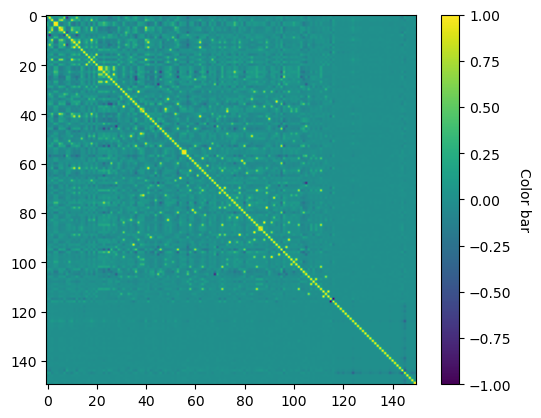

In [207]:
fig, ax = plt.subplots()
im = ax.imshow(X.corr())

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Color bar", rotation = -90, va = "bottom")

In [72]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(penalty='elasticnet', solver='saga')

params = {'C': [1],
          'l1_ratio': [0.5, 0.75, 1]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)



Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=1, l1_ratio=0.5; total time=   9.1s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=1, l1_ratio=0.5; total time=   9.6s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=1, l1_ratio=0.5; total time=   9.5s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=1, l1_ratio=0.5; total time=   9.6s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=1, l1_ratio=0.5; total time=   9.5s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=1, l1_ratio=0.75; total time=   8.8s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=1, l1_ratio=0.75; total time=   9.3s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=1, l1_ratio=0.75; total time=   9.8s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=1, l1_ratio=0.75; total time=   9.4s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=1, l1_ratio=0.75; total time=   9.2s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................................C=1, l1_ratio=1; total time=   8.7s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................................C=1, l1_ratio=1; total time=   9.2s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................................C=1, l1_ratio=1; total time=   9.0s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................................C=1, l1_ratio=1; total time=   9.0s


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................................C=1, l1_ratio=1; total time=   8.9s
{'C': 1, 'l1_ratio': 0.75}


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [35]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.log10(np.array(params[p]))
        #x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel('lg('+p.upper()+')')
        #ax[i].set_xlabel(p.upper())

    #plt.legend()
    plt.show()

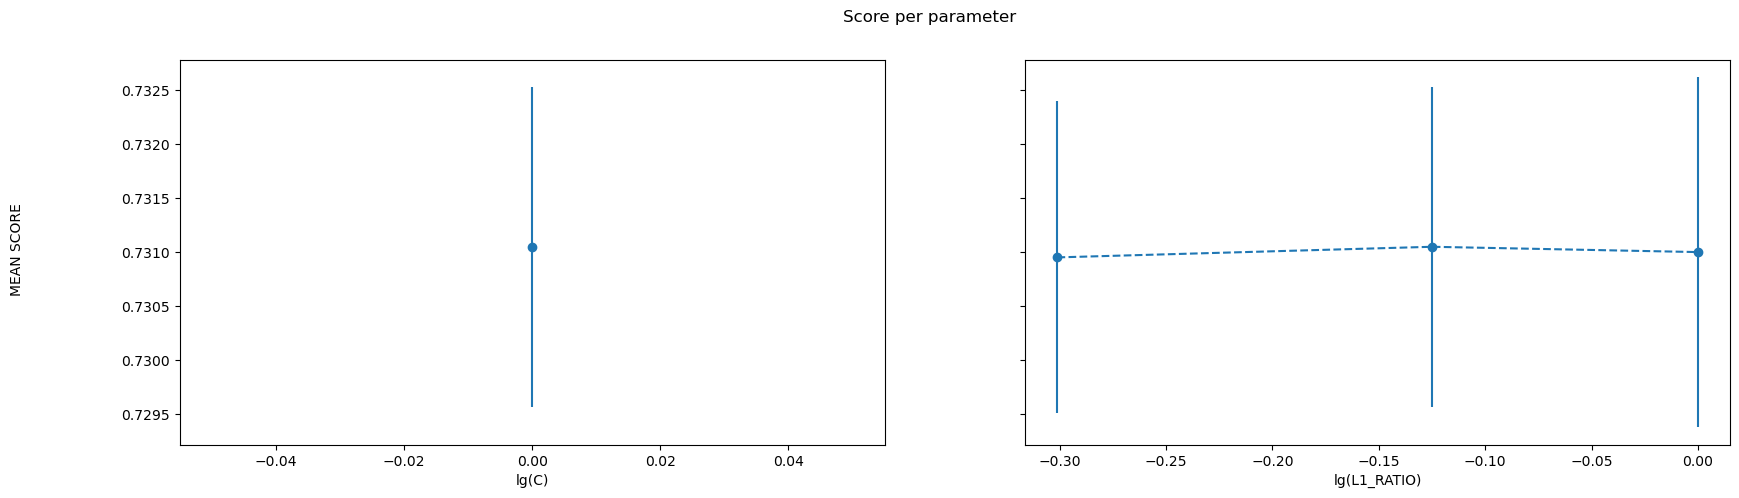

In [73]:
plot_search_results(grid)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
enet = LogisticRegression(penalty='elasticnet', solver='saga', C=0.1, l1_ratio=0.75)
enet.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = enet.predict_proba(x_test)[:,1]
y_pred = enet.predict(x_test)
print(enet.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7307541241162608
              precision    recall  f1-score   support

           0       0.65      0.42      0.51      3407
           1       0.75      0.89      0.81      6777

    accuracy                           0.73     10184
   macro avg       0.70      0.65      0.66     10184
weighted avg       0.72      0.73      0.71     10184



C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### SVM

In [24]:
# It takes centuries to run
#from sklearn.feature_selection import SequentialFeatureSelector

#svm = SVC(kernel='rbf')

#sfs_forward = SequentialFeatureSelector(svm, direction="forward").fit(X, Y)
#print(feature_names[sfs_forward.get_support()])

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC(kernel='rbf')

params = {'C': [0.1, 1]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [21]:
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
svm = SVC(kernel='rbf', probability=True)
svm.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = svm.predict_proba(x_test)[:,1]
y_pred = svm.predict(x_test)
print(svm.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.733503534956795
              precision    recall  f1-score   support

           0       0.69      0.37      0.48      3407
           1       0.74      0.92      0.82      6777

    accuracy                           0.73     10184
   macro avg       0.72      0.64      0.65     10184
weighted avg       0.73      0.73      0.71     10184



### Ensemble methods 

#### Gradient-boosted trees

In [42]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier()

params = {'max_iter': [50, 100, 200]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_iter=50; total time=   2.7s
[CV] END ........................................max_iter=50; total time=   2.8s
[CV] END ........................................max_iter=50; total time=   2.8s
[CV] END ........................................max_iter=50; total time=   2.6s
[CV] END ........................................max_iter=50; total time=   2.7s
[CV] END .......................................max_iter=100; total time=   4.9s
[CV] END .......................................max_iter=100; total time=   4.1s
[CV] END .......................................max_iter=100; total time=   4.7s
[CV] END .......................................max_iter=100; total time=   4.9s
[CV] END .......................................max_iter=100; total time=   3.8s
[CV] END .......................................max_iter=200; total time=   5.1s
[CV] END .......................................m

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model = HistGradientBoostingClassifier(max_iter=100)
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7438138256087982
              precision    recall  f1-score   support

           0       0.68      0.45      0.54      3407
           1       0.76      0.89      0.82      6777

    accuracy                           0.74     10184
   macro avg       0.72      0.67      0.68     10184
weighted avg       0.73      0.74      0.73     10184



#### Random Forests

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(max_features='sqrt')

params = {'n_estimators': [50, 100, 200, 400]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................................n_estimators=50; total time=   8.0s
[CV] END ....................................n_estimators=50; total time=   7.8s
[CV] END ....................................n_estimators=50; total time=   7.8s
[CV] END ....................................n_estimators=50; total time=   7.8s
[CV] END ....................................n_estimators=50; total time=   7.7s
[CV] END ...................................n_estimators=100; total time=  15.5s
[CV] END ...................................n_estimators=100; total time=  15.4s
[CV] END ...................................n_estimators=100; total time=  15.3s
[CV] END ...................................n_estimators=100; total time=  15.6s
[CV] END ...................................n_estimators=100; total time=  15.9s
[CV] END ...................................n_estimators=200; total time=  31.2s
[CV] END ...................................n_est

In [37]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model = RandomForestClassifier(n_estimators=400, max_features='sqrt')
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7351728201099764
              precision    recall  f1-score   support

           0       0.70      0.36      0.48      3407
           1       0.74      0.92      0.82      6777

    accuracy                           0.74     10184
   macro avg       0.72      0.64      0.65     10184
weighted avg       0.73      0.74      0.71     10184



#### AdaBoost 

In [45]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

params = {'n_estimators': [50, 100, 200],
         'learning_rate': [0.1, 1, 10]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  11.4s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  11.1s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  11.1s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  11.2s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  11.1s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.3s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.3s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.3s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.7s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.3s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=  44.5s
[CV] END ................learning_rate=0.1, n_est

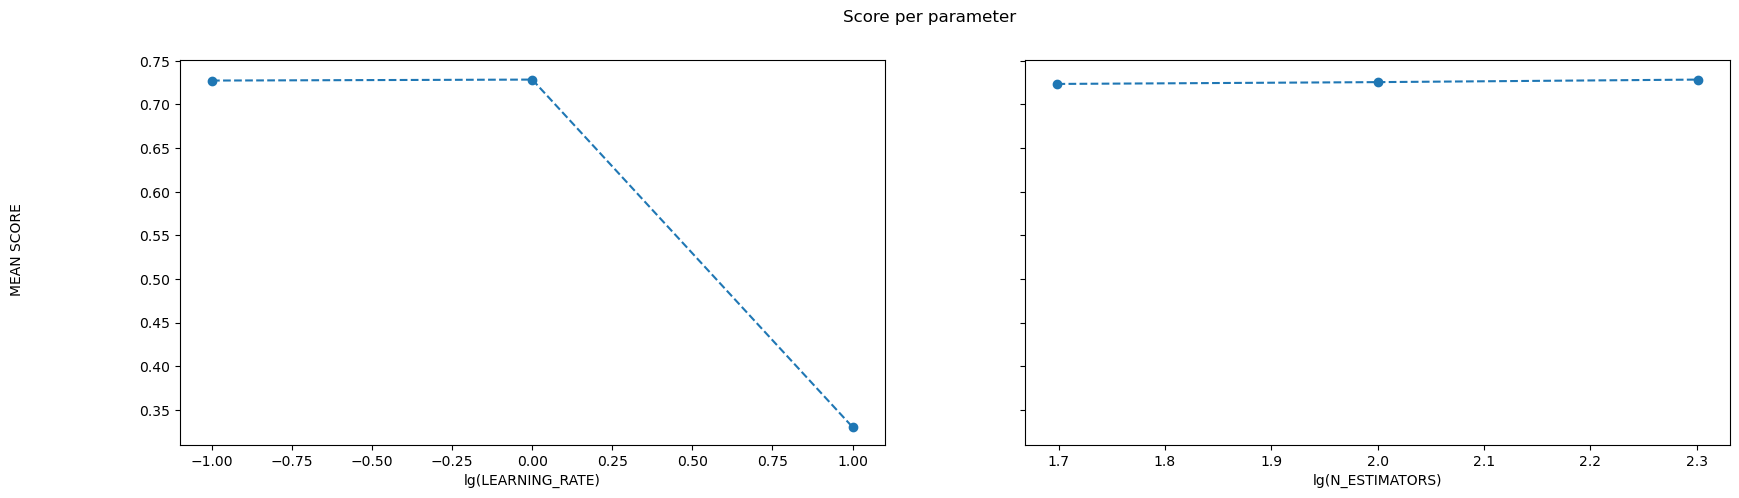

In [46]:
plot_search_results(grid)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model = AdaBoostClassifier(n_estimators=200, learning_rate=1)
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7341908876669285
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      3407
           1       0.76      0.87      0.81      6777

    accuracy                           0.73     10184
   macro avg       0.70      0.67      0.68     10184
weighted avg       0.72      0.73      0.72     10184



#### Bagging method

In [49]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(max_samples=0.5, max_features=0.5)

params = {'n_estimators': [10, 20, 40]}

grid = GridSearchCV(model, params, refit=True, verbose=2)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
grid.fit(x_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=10; total time=   5.9s
[CV] END ....................................n_estimators=10; total time=   5.7s
[CV] END ....................................n_estimators=10; total time=   5.9s
[CV] END ....................................n_estimators=10; total time=   5.9s
[CV] END ....................................n_estimators=10; total time=   5.8s
[CV] END ....................................n_estimators=20; total time=  11.8s
[CV] END ....................................n_estimators=20; total time=  11.5s
[CV] END ....................................n_estimators=20; total time=  11.6s
[CV] END ....................................n_estimators=20; total time=  13.0s
[CV] END ....................................n_estimators=20; total time=  12.0s
[CV] END ....................................n_estimators=40; total time=  23.7s
[CV] END ....................................n_es

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model = BaggingClassifier(max_samples=0.5, max_features=0.5, n_estimators=40)
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.7231932443047918
              precision    recall  f1-score   support

           0       0.64      0.39      0.48      3407
           1       0.74      0.89      0.81      6777

    accuracy                           0.72     10184
   macro avg       0.69      0.64      0.65     10184
weighted avg       0.71      0.72      0.70     10184



#### Stack of estimators with a final classifier

In [53]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('enet', LogisticRegression(penalty='elasticnet', solver='saga', C=0.01, l1_ratio=0.2)),
    ('rf', RandomForestClassifier(n_estimators=400, max_features='sqrt')),
    ('boosting', HistGradientBoostingClassifier(max_iter=100))]

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_mode

0.746268656716418
              precision    recall  f1-score   support

           0       0.68      0.46      0.55      3407
           1       0.77      0.89      0.82      6777

    accuracy                           0.75     10184
   macro avg       0.72      0.67      0.69     10184
weighted avg       0.74      0.75      0.73     10184



#### Soft Voting

In [60]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=estimators,
                         voting='soft', weights=[1, 1, 1])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
model.fit(x_train, y_train)
x_test = scaler.transform(x_test)
y_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(classification_report(y_test, y_pred))

C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7419481539670071
              precision    recall  f1-score   support

           0       0.70      0.40      0.51      3407
           1       0.75      0.91      0.82      6777

    accuracy                           0.74     10184
   macro avg       0.72      0.66      0.67     10184
weighted avg       0.73      0.74      0.72     10184



### Model comparison

0.7623196676165898


Text(0.5, 0, 'False Positive Rate')

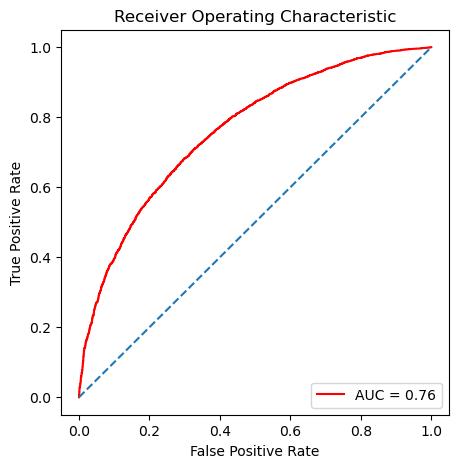

In [66]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\WangJiachuan\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


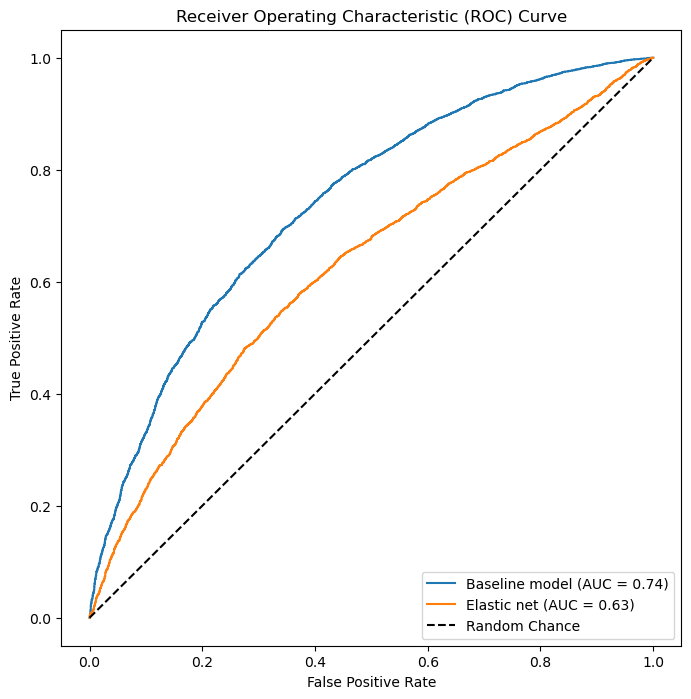

In [79]:
models = [LogisticRegression(penalty='none'),
          LogisticRegression(penalty='elasticnet', solver='saga', C=1, l1_ratio=0.75),
          #BaggingClassifier(max_samples=0.5, max_features=0.5, n_estimators=40),
          #AdaBoostClassifier(n_estimators=200, learning_rate=1),
          #RandomForestClassifier(n_estimators=400, max_features='sqrt'),
          #HistGradientBoostingClassifier(max_iter=100),
          #VotingClassifier(estimators=estimators, voting='soft', weights=[1, 1, 1])
         ]
#model_names = ['Baseline model', 'Elastic net', 'Bagging', 'AdaBoost', 'Random forest', 'Gradient Boosting', 'Ensemble learning']
model_names = ['Baseline model', 'Elastic net']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

plt.figure(figsize=(8, 8))

for model, name in zip(models, model_names):
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.legend(loc = 'lower right')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.axis('tight')

# Show the plot
plt.show()